# XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

# Data Integration

In [3]:
# sorting data & predictors
db = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
db.drop_duplicates(inplace = True)

In [4]:
db = db[db["Diabetes_012"] != 1] # drop prediabetes
db['Diabetes_012'] = db['Diabetes_012'].replace(2,1)

i_keep_0 = db[db['Diabetes_012'] == 0].sample(n = db['Diabetes_012'].value_counts()[1],
                                   replace=False,
                                   random_state = 1).index

i_keep_all = db[db['Diabetes_012'] == 1].index.append(i_keep_0).sort_values()

db = db.loc[i_keep_all].reset_index(drop=True)

In [24]:
# subsetting predictors
db_main = db[['Diabetes_012', 'BMI', 'HighBP', 'HighChol', 'Sex', 'Age']]
print(db_main.head(10))

   Diabetes_012   BMI  HighBP  HighChol  Sex   Age
0           0.0  25.0     0.0       0.0  0.0   7.0
1           0.0  27.0     1.0       0.0  0.0  11.0
2           0.0  24.0     1.0       1.0  0.0  11.0
3           1.0  30.0     1.0       1.0  0.0   9.0
4           1.0  25.0     0.0       0.0  1.0  13.0
5           1.0  28.0     1.0       1.0  0.0  11.0
6           0.0  21.0     1.0       1.0  0.0  10.0
7           1.0  23.0     0.0       0.0  1.0   7.0
8           0.0  23.0     0.0       0.0  0.0   2.0
9           1.0  27.0     1.0       0.0  0.0  13.0


# Model Building

In [66]:
x = db_main.drop('Diabetes_012', axis = 1)


scaler = MinMaxScaler(feature_range = (0, 1))
xresc = scaler.fit_transform(x)
x = pd.DataFrame(data = x, columns = x.columns)


y = db_main['Diabetes_012']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1, random_state = 1)
print(xtrain)

        BMI  HighBP  HighChol  Sex   Age
23171  28.0     1.0       1.0  0.0  10.0
58306  32.0     1.0       1.0  0.0  11.0
69947  28.0     1.0       1.0  0.0   7.0
23265  33.0     1.0       1.0  1.0   8.0
31645  27.0     0.0       1.0  0.0  12.0
...     ...     ...       ...  ...   ...
49100  21.0     1.0       1.0  0.0  12.0
20609  18.0     0.0       0.0  0.0   3.0
21440  54.0     1.0       0.0  0.0   8.0
50057  36.0     1.0       1.0  1.0   5.0
5192   27.0     1.0       1.0  0.0   7.0

[63174 rows x 5 columns]


In [67]:
xgb_clf = xgb.XGBClassifier(n_estimators = 88, learning_rate = 0.35, 
                            max_depth = 3, seed = 1)
xgb_clf.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.35, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=88, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [68]:
pred = xgb_clf.predict(xtest)
print(xtest.head(10))
print(pred)

        BMI  HighBP  HighChol  Sex   Age
36091  24.0     0.0       0.0  0.0   9.0
50778  21.0     0.0       0.0  0.0   3.0
25311  30.0     1.0       1.0  0.0  11.0
12805  27.0     1.0       1.0  0.0  13.0
21248  41.0     1.0       0.0  0.0   6.0
2009   41.0     0.0       0.0  0.0   5.0
36355  27.0     0.0       0.0  0.0  13.0
69454  28.0     0.0       1.0  1.0  10.0
56293  39.0     0.0       0.0  0.0   5.0
42251  26.0     1.0       1.0  1.0  10.0
[0 0 1 ... 1 0 0]


In [44]:
print(f'Training MSE: {round(mean_squared_error(xgb_clf.predict(xtrain), ytrain), 4)}')
print(f'Testing MSE: {round(mean_squared_error(pred, ytest), 4)}')

Training MSE: 0.2855
Testing MSE: 0.2862


In [69]:
print(classification_report(ytest, pred,
                            digits = 4,
                            target_names = ["No Diabetes", "Diabetes"],
                            zero_division = 1))

              precision    recall  f1-score   support

 No Diabetes     0.7467    0.6643    0.7031      3581
    Diabetes     0.6865    0.7653    0.7238      3439

    accuracy                         0.7138      7020
   macro avg     0.7166    0.7148    0.7134      7020
weighted avg     0.7172    0.7138    0.7132      7020



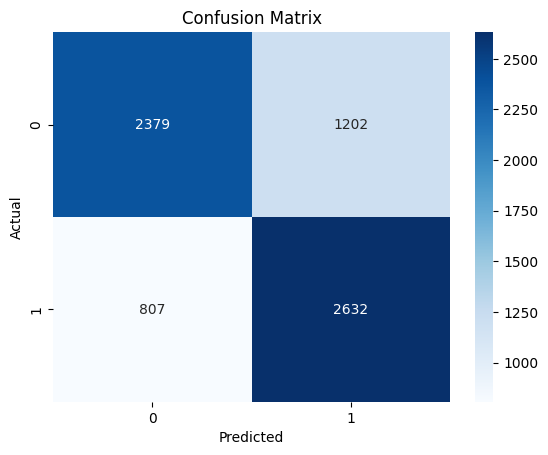

In [70]:
cm = confusion_matrix(ytest, pred)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [78]:
# Create a new input sample for testing
new_input = pd.DataFrame({
    'BMI': [25],
    'HighBP': [1],
    'HighChol': [1],
    'Sex': [1],
    'Age': [7],
})



# Predict the output for the new input
prediction = xgb_clf.predict(new_input)

# Display the prediction
print("Prediction for the new input:", prediction[0])

Prediction for the new input: 1


# Chosen Model

In [76]:
import pickle

with open('XGB.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)